# Project LeukoLense_LuL

##1. Mount Google Drive

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.Install Important Libraries

In [65]:
!pip install tensorflow
!pip install keras
!pip install opencv-python-headless==4.1.2.30
!pip install google-colab

ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80)
ERROR: No matching distribution found for opencv-python-headless==4.1.2.30


### 3.Import Necessary Libraries

In [66]:
import os
import json
import numpy as np
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

### 4. Load Data and Annotate Images

In [67]:
# Define the paths to the image and annotation directories
image_dir = '/content/drive/MyDrive/LeukoLense_LuL/DataSet/BoneMarrowDataset/images'
json_dir = '/content/drive/MyDrive/LeukoLense_LuL/DataSet/BoneMarrowDataset/annotations'

# List image and annotation files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]

# Strip extensions for comparison
image_basenames = [os.path.splitext(f)[0] for f in image_files]
json_basenames = [os.path.splitext(f)[0] for f in json_files]

# Find mismatches
missing_json = [f for f in image_basenames if f not in json_basenames]
missing_images = [f for f in json_basenames if f not in image_basenames]

# Report mismatches
print(f"Total images found: {len(image_files)}")
print(f"Total annotations found: {len(json_files)}\n")

if missing_json:
    print("Images without corresponding annotations:")
    for name in missing_json:
        print(f"{name}.jpg or {name}.png")
else:
    print("All images have corresponding annotations.")

if missing_images:
    print("\nAnnotations without corresponding images:")
    for name in missing_images:
        print(f"{name}.json")
else:
    print("All annotations have corresponding images.")


Total images found: 61
Total annotations found: 58

Images without corresponding annotations:
Copy of ART_00007.jpg or Copy of ART_00007.png
Copy of ART_00009.jpg or Copy of ART_00009.png
Copy of ABE_00004.jpg or Copy of ABE_00004.png
All annotations have corresponding images.


Loaded 61 images and 61 masks.


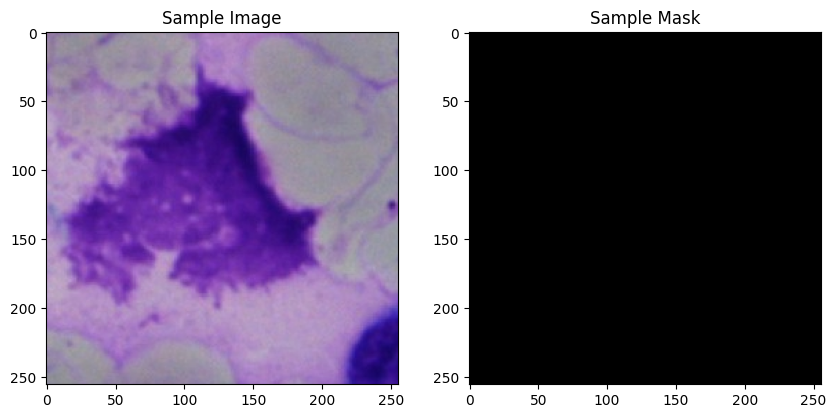

In [68]:
def load_annotations(json_folder):
    annotations = {}
    for json_file in os.listdir(json_folder):
        if json_file.endswith(".json"):
            with open(os.path.join(json_folder, json_file)) as f:
                data = json.load(f)
                filename = data["imagePath"]
                shapes = data["shapes"]
                annotations[filename] = shapes
    return annotations

def create_mask_from_annotation(shapes, img_size=(256, 256)):
    mask = np.zeros(img_size, dtype=np.uint8)
    for shape in shapes:
        if shape["shape_type"] == "polygon":
            all_points_x = [int(point[0]) for point in shape["points"]]
            all_points_y = [int(point[1]) for point in shape["points"]]
            points = np.array([list(zip(all_points_x, all_points_y))], dtype=np.int32)
            cv2.fillPoly(mask, points, 255)
    return mask

def load_and_annotate_data(image_dir, json_dir):
    images = []
    masks = []
    annotations = load_annotations(json_dir)

    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path, target_size=(256, 256))
            img_array = img_to_array(img)
            images.append(img_array)

            if filename in annotations:
                shapes = annotations[filename]
                mask = create_mask_from_annotation(shapes)
            else:
                mask = np.zeros((256, 256), dtype=np.uint8)

            mask = np.expand_dims(mask, axis=-1)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Path to your image directory and JSON annotations in Google Drive
image_dir = '/content/drive/MyDrive/LeukoLense_LuL/DataSet/BoneMarrowDataset/images'
json_dir = '/content/drive/MyDrive/LeukoLense_LuL/DataSet/BoneMarrowDataset/annotations'

X, Y = load_and_annotate_data(image_dir, json_dir)
print(f"Loaded {len(X)} images and {len(Y)} masks.")

# Display a sample image and its corresponding mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Sample Image')
plt.imshow(X[0].astype('uint8'))
plt.subplot(1, 2, 2)
plt.title('Sample Mask')
plt.imshow(Y[0].squeeze(), cmap='gray')
plt.show()


###5.Split Data into Training and Testing Sets

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(f"Training set: {len(X_train)} images, {len(Y_train)} masks")
print(f"Testing set: {len(X_test)} images, {len(Y_test)} masks")

Training set: 42 images, 42 masks
Testing set: 19 images, 19 masks


###6.Define U-Net Model

In [70]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the model
model = unet_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 256, 256, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 dropout_27 (Dropout)        (None, 256, 256, 64)         0         ['conv2d_57[0][0]']           
                                                                                                  
 conv2d_58 (Conv2D)          (None, 256, 256, 64)         36928     ['dropout_27[0][0]']          
                                                                                            

###7.Train the Model:

In [71]:
# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=2,
    validation_data=(X_test, Y_test)
)


Epoch 1/10
21/21 [==============================] - 10s 199ms/step - loss: 1368.0543 - accuracy: 0.9551 - val_loss: 676.8817 - val_accuracy: 0.9432
Epoch 2/10
21/21 [==============================] - 4s 187ms/step - loss: -124.8135 - accuracy: 0.5342 - val_loss: -611.1207 - val_accuracy: 0.0083
Epoch 3/10
21/21 [==============================] - 4s 188ms/step - loss: -327.6153 - accuracy: 0.0098 - val_loss: -1517.1097 - val_accuracy: 2.5699e-05
Epoch 4/10
21/21 [==============================] - 4s 189ms/step - loss: -737.1857 - accuracy: 9.7002e-05 - val_loss: -2013.6293 - val_accuracy: 8.0309e-06
Epoch 5/10
21/21 [==============================] - 4s 191ms/step - loss: -1112.1624 - accuracy: 2.1072e-05 - val_loss: -4448.9849 - val_accuracy: 0.0000e+00
Epoch 6/10
21/21 [==============================] - 4s 190ms/step - loss: -2274.3809 - accuracy: 1.8165e-06 - val_loss: -12521.6670 - val_accuracy: 0.0000e+00
Epoch 7/10
21/21 [==============================] - 4s 188ms/step - loss: -37

###8.Save the model

In [61]:
model.save('/content/drive/MyDrive/LeukoLense_LuL/BoneMarrowDataset/unet_model.h5')
print("Model saved successfully.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


###2. Fine-Tune the Model
####2.1 Data Augmentation

In [62]:
# Import the necessary module
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, Y_train, batch_size=4)
val_generator = val_datagen.flow(X_test, Y_test, batch_size=4)

####2.2 Adjust Learning Rate and Retrain

In [63]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Retrain the model with fine-tuning
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[reduce_lr]
)


Epoch 1/50
11/11 [==============================] - 9s 727ms/step - loss: -6.8524 - accuracy: 3.7057e-05 - val_loss: -13.3951 - val_accuracy: 5.6217e-06 - lr: 1.0000e-04
Epoch 2/50
11/11 [==============================] - 3s 311ms/step - loss: -9.3347 - accuracy: 2.2525e-05 - val_loss: -13.8509 - val_accuracy: 4.0155e-06 - lr: 1.0000e-04
Epoch 3/50
11/11 [==============================] - 3s 312ms/step - loss: -8.7417 - accuracy: 1.8529e-05 - val_loss: -14.0398 - val_accuracy: 4.0155e-06 - lr: 1.0000e-04
Epoch 4/50
11/11 [==============================] - 3s 324ms/step - loss: -7.9072 - accuracy: 2.0708e-05 - val_loss: -14.1214 - val_accuracy: 2.4093e-06 - lr: 1.0000e-04
Epoch 5/50
11/11 [==============================] - 3s 313ms/step - loss: -8.6285 - accuracy: 1.9618e-05 - val_loss: -14.1976 - val_accuracy: 2.4093e-06 - lr: 1.0000e-04
Epoch 6/50
11/11 [==============================] - 3s 314ms/step - loss: -7.7770 - accuracy: 1.4532e-05 - val_loss: -14.2911 - val_accuracy: 2.4093e-

KeyboardInterrupt: 

####3. Save the Fine-Tuned Model

In [ ]:
# Save the fine-tuned model
model.save('/content/drive/MyDrive/LeukoLense_LuL/LeukoLense_model_finetuned.h5')
print("Fine-tuned model saved successfully.")


###3.1 Load the Model

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model_path = '/content/drive/MyDrive/LeukoLense_LuL/LeukoLense_model_finetuned.h5'
model = load_model(model_path)


###3.2 Load Test Data

In [ ]:
# Function to load data and generate masks
def load_test_data(image_dir):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path, target_size=(256, 256))
            img_array = img_to_array(img)
            images.append(img_array)

            # Generate dummy mask for demonstration (real masks should be loaded similarly)
            mask = np.zeros((256, 256, 1))
            mask_path = os.path.join(image_dir, filename.replace('.jpg', '_mask.png'))
            if os.path.exists(mask_path):
                mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale")
                mask = img_to_array(mask)
            masks.append(mask)
    return np.array(images), np.array(masks)

# Path to your test image directory
test_image_dir = '/content/drive/MyDrive/LeukoLense_LuL/DataSet/BoneMarrowDataset/test_images'

X_test, Y_test = load_test_data(test_image_dir)
X_test = X_test / 255.0  # Normalize images
print(f"Loaded {len(X_test)} test images and {len(Y_test)} test masks.")


# Display a sample image and its corresponding mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Sample Image')
plt.imshow(X[0].astype('uint8'))
plt.subplot(1, 2, 2)
plt.title('Sample Mask')
plt.imshow(Y[0].squeeze(), cmap='gray')
plt.show()


###3.3 Evaluate the Model

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=4)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


### 3.4 Make Predictions

In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Visualize a few predictions
import matplotlib.pyplot as plt

for i in range(3):  # Display first 3 images and their predictions
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(X_test[i])

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(Y_test[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predictions[i].squeeze(), cmap='gray')

    plt.show()


###4.1 Visual Inspection

In [ ]:
import matplotlib.pyplot as plt

# Visualize a few predictions
for i in range(4):  # Display first 4 images and their predictions
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(X_test[i])

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(Y_test[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predictions[i].squeeze(), cmap='gray')

    plt.show()


###4.2 Quantitative Metrics

In [ ]:
def iou_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return 2. * intersection / (np.sum(y_true) + np.sum(y_pred))

ious = []
dice_scores = []

for i in range(len(Y_test)):
    true_mask = Y_test[i].squeeze()
    pred_mask = predictions[i].squeeze().round()  # Binarize the predictions

    ious.append(iou_score(true_mask, pred_mask))
    dice_scores.append(dice_coefficient(true_mask, pred_mask))

print(f"Average IoU: {np.mean(ious)}")
print(f"Average Dice Coefficient: {np.mean(dice_scores)}")


###5.1 Handle Empty Masks

In [ ]:
def iou_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    if union == 0:
        return 1.0  # Consider perfect score if both are empty
    return intersection / union

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    sum_y_true_y_pred = np.sum(y_true) + np.sum(y_pred)
    if sum_y_true_y_pred == 0:
        return 1.0  # Consider perfect score if both are empty
    return 2. * intersection / sum_y_true_y_pred

ious = []
dice_scores = []

for i in range(len(Y_test)):
    true_mask = Y_test[i].squeeze()
    pred_mask = predictions[i].squeeze().round()  # Binarize the predictions

    ious.append(iou_score(true_mask, pred_mask))
    dice_scores.append(dice_coefficient(true_mask, pred_mask))

print(f"Average IoU: {np.mean(ious)}")
print(f"Average Dice Coefficient: {np.mean(dice_scores)}")
